In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tqdm import tqdm
from torchvision.utils import make_grid, save_image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [128]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

**1. Вибір та підготовка набору даних**

**2. Попередня обробка даних**

In [129]:
random_seed = 42
batch_size = 128

In [130]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data',
                                train = True,
                                download=True,
                                transform=transform)

test_dataset = datasets.FashionMNIST(root='./data',
                                     train = False,
                                     download=True,
                                     transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [85]:
print(f'Train dataset {len(train_dataset)}')
print(f'Train dataloader {len(train_loader)}')
print(f'Test dataset {len(test_dataset)}')
print(f'Test dataloader {len(test_loader)}')

Train dataset 60000
Train dataloader 469
Test dataset 10000
Test dataloader 79


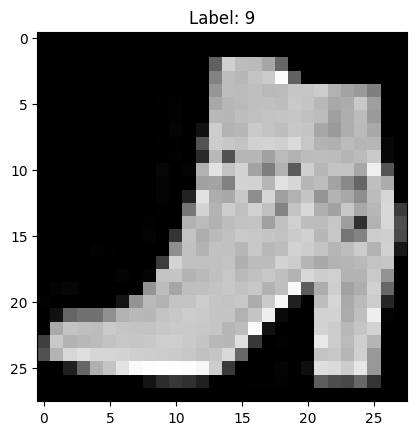

In [131]:
# Перевірка прикладу зображення
examples = iter(train_loader)
example_data, example_targets = next(examples)
plt.imshow(example_data[0][0], cmap='gray')
plt.title(f'Label: {example_targets[0]}')
plt.show()

**3. Реалізація архітектури VAE**

In [132]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc21 = nn.Linear(500, latent_dim)  # fc21 for mean of Z
        self.fc22 = nn.Linear(500, latent_dim)  # fc22 for log variance of Z
        self.fc3 = nn.Linear(latent_dim, 500)
        self.fc4 = nn.Linear(500, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        # I guess the reason for using logvar instead of std or var is that
        # the output of fc22 can be negative value (std and var should be positive)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.rand_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # x: [batch size, 1, 28,28] -> x: [batch size, 784]
        x = x.view(-1, 784)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum') / x.size(0)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + beta * kld_loss

**4. Налаштування функцій втрат**


*   Навчання моделі
*   Генерація нових даних
*   Аналіз результатів
*   Документування висновків



In [148]:
def save_generated_img(image, name, epoch, nrow=8):
    if not os.path.exists('./data/result'):
        os.makedirs('./data/result')

    if epoch % 1 == 0:
        save_path = './data/result/'+name+'_'+str(epoch)+'.png'
        save_image(image, save_path, nrow=nrow)

def sample_from_model(epoch):
    with torch.no_grad():
        # p(z) = N(0,I), this distribution is used when calculating KLD. So we can sample z from N(0,I)
        sample = torch.randn(64, latent_dim).to(device)
        sample = model.decode(sample).cpu().view(64, 1, 28, 28)
        save_generated_img(sample, 'sample', epoch)


def plot_losses(train_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title(f"Training Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    path = os.path.join("./data/result/", f"train_losses.png")
    plt.savefig(path)
    plt.close()

In [151]:
latent_dim = 2
num_epochs = 5
learning_rate = 0.001
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [155]:
def train(num_epochs):

    train_losses = []

    for epoch in range(num_epochs):

      model.train()
      train_loss = 0

      for batch_idx, (data, label) in enumerate(train_loader):
          # data: [batch size, 1, 28, 28]
          optimizer.zero_grad()
          data = data.to(device)
          recon_data, mu, logvar = model(data)
          loss = loss_function(recon_data, data, mu, logvar)
          loss.backward()
          cur_loss = loss.item()
          train_loss += cur_loss
          optimizer.step()

          if batch_idx % 100 == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch+1, batch_idx * len(data), len(train_loader.dataset),
                  100.*batch_idx / len(train_loader),
                  cur_loss/len(data)))


      train_losses.append(train_loss / len(train_loader.dataset))

      print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)
      ))

    plot_losses(train_losses)


def test(num_epochs):

    for epoch in range(num_epochs):

      model.eval()
      test_loss = 0
      with torch.no_grad():
          for batch_idx, (data, label) in enumerate(test_loader):
              data = data.to(device)
              recon_data, mu, logvar = model(data)
              cur_loss = loss_function(recon_data, data, mu, logvar).item()
              test_loss += cur_loss
              if batch_idx == 0:
                  # saves 8 samples of the first batch as an image file to compare input images and reconstructed images
                  num_samples = min(batch_size, 8)
                  comparison = torch.cat(
                      [data[:num_samples], recon_data.view(batch_size, 1, 28, 28)[:num_samples]]).cpu()
                  save_generated_img(comparison, 'reconstruction', epoch, num_samples)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [153]:
#Тренування
train(num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 8.562716
Train Epoch: 1 [12800/60000 (21%)]	Loss: 4.094111
Train Epoch: 1 [25600/60000 (43%)]	Loss: 4.066965
Train Epoch: 1 [38400/60000 (64%)]	Loss: 4.100491
Train Epoch: 1 [51200/60000 (85%)]	Loss: 4.138402
====> Epoch: 1 Average loss: 4.2266
Train Epoch: 2 [0/60000 (0%)]	Loss: 4.034799
Train Epoch: 2 [12800/60000 (21%)]	Loss: 4.194203
Train Epoch: 2 [25600/60000 (43%)]	Loss: 4.064730
Train Epoch: 2 [38400/60000 (64%)]	Loss: 4.112405
Train Epoch: 2 [51200/60000 (85%)]	Loss: 4.050801
====> Epoch: 2 Average loss: 4.0712
Train Epoch: 3 [0/60000 (0%)]	Loss: 4.036766
Train Epoch: 3 [12800/60000 (21%)]	Loss: 4.062459
Train Epoch: 3 [25600/60000 (43%)]	Loss: 3.995591
Train Epoch: 3 [38400/60000 (64%)]	Loss: 3.948399
Train Epoch: 3 [51200/60000 (85%)]	Loss: 3.918973
====> Epoch: 3 Average loss: 4.0643
Train Epoch: 4 [0/60000 (0%)]	Loss: 3.991339
Train Epoch: 4 [12800/60000 (21%)]	Loss: 3.971767
Train Epoch: 4 [25600/60000 (43%)]	Loss: 4.118728
Train Epoch:

In [156]:
#Тестування
test(num_epochs)

====> Test set loss: 4.0832


In [157]:
#Генерація нових картинок
sample_from_model(num_epochs)